# 0. Load Libraries

In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import metacells as mc
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
import seaborn as sb

from math import hypot
from matplotlib.collections import LineCollection
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('svg')
sb.set_style("white")

# 1. Read data

In [2]:
raw = ad.read_h5ad('/mnt/data/SC-Reynolds-2021/metacells/pbmc163k.h5ad')
mc.ut.set_name(raw, 'PBMC')
print(raw.shape)

(163234, 32738)


# 2. Cleaning data

## 2.1 Cleaning genes

In [3]:
# exclude genes by names
excluded_gene_names = ['IGHMBP2', 'IGLL1', 'IGLL5', 'IGLON5', 'NEAT1', 'TMSB10', 'TMSB4X']
excluded_gene_patterns = ['MT-.*']

# also automatically remove 
# 1. genes by name and patterns
# 2. genes that have 0 total UMI (properly_sampled_gene; default is UMI>=1, you can specify other threshold)
# 3. genes which have a significant expression level but no significant correlation with any other gene (noisy_lonely_gene)

mc.pl.analyze_clean_genes(raw,
      excluded_gene_names=excluded_gene_names,
      excluded_gene_patterns=excluded_gene_patterns,
      random_seed=123456)

# the above function will add per-gene annotation for filtering later:
# excluded_gene, properly_sampled_gene, noisy_lonely_gene

# combine all these mask into a final clean_gene mask
mc.pl.pick_clean_genes(raw)

set PBMC.var[properly_sampled_gene]: 22637 true (69.15%) out of 32738 bools
set PBMC.var[excluded_gene]: 20 true (0.06109%) out of 32738 bools
set PBMC.var[noisy_lonely_gene]: 0 true (0%) out of 32738 bools
set PBMC.var[clean_gene]: 22617 true (69.08%) out of 32738 bools


In [4]:
raw.write('/mnt/data/SC-Reynolds-2021/metacells/full.h5ad')
full = raw

## 2.2 Cleaning cells

> two criteria: 
> 1. the total number of UMIs for each cell
> 2. the fraction of these UMIs that come from excluded (non-clean) genes

### 2.2.1 Total number of UMIs for each cell

In [5]:
# calculate total UMIs
total_umis_of_cells = mc.ut.get_o_numpy(full, name='__x__', sum=True)

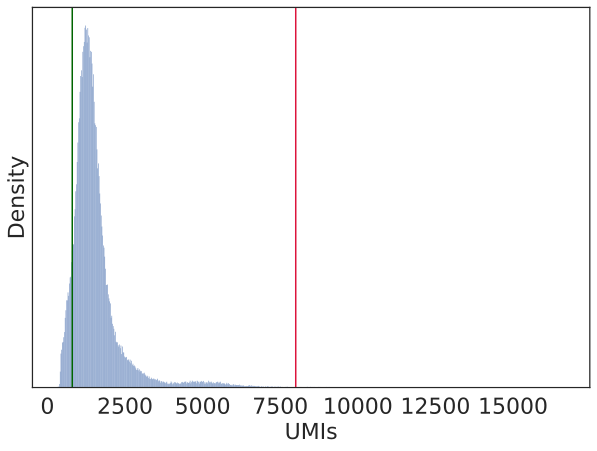

In [6]:
# make some plot
properly_sampled_min_cell_total = 800
properly_sampled_max_cell_total = 8000

plot = sb.histplot(total_umis_of_cells)
plot.set(xlabel='UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_min_cell_total, color='darkgreen')
plot.axvline(x=properly_sampled_max_cell_total, color='crimson')
plt.show()

In [7]:
# get some statistics
too_small_cells_count = sum(total_umis_of_cells < properly_sampled_min_cell_total)
too_large_cells_count = sum(total_umis_of_cells > properly_sampled_max_cell_total)

too_small_cells_percent = 100.0 * too_small_cells_count / len(total_umis_of_cells)
too_large_cells_percent = 100.0 * too_large_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with less than %s UMIs"
      % (too_small_cells_count,
         too_small_cells_percent,
         properly_sampled_min_cell_total))
print(f"Will exclude %s (%.2f%%) cells with more than %s UMIs"
      % (too_large_cells_count,
         too_large_cells_percent,
         properly_sampled_max_cell_total))

Will exclude 12983 (7.95%) cells with less than 800 UMIs
Will exclude 349 (0.21%) cells with more than 8000 UMIs


### 2.2.2 Fraction of these UMIs that come from excluded (non-clean) genes

In [8]:
# calculate the fraction of UMIs coming from non-clean genes
excluded_genes_data = mc.tl.filter_data(full, var_masks=['~clean_gene'])[0]
excluded_umis_of_cells = mc.ut.get_o_numpy(excluded_genes_data, name='__x__', sum=True)
excluded_fraction_of_umis_of_cells = excluded_umis_of_cells / total_umis_of_cells

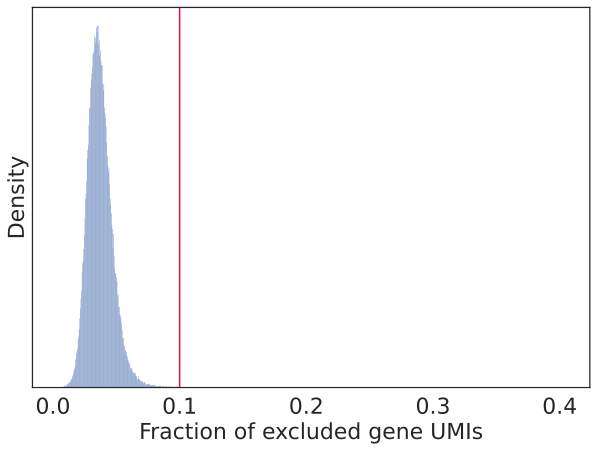

In [9]:
# make some plot
properly_sampled_max_excluded_genes_fraction = 0.1

plot = sb.histplot(excluded_fraction_of_umis_of_cells)
plot.set(xlabel='Fraction of excluded gene UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_max_excluded_genes_fraction, color='crimson')
plt.show()

In [10]:
# get some statistics
too_excluded_cells_count = sum(excluded_fraction_of_umis_of_cells > properly_sampled_max_excluded_genes_fraction)
too_excluded_cells_percent = 100.0 * too_excluded_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with more than %.2f%% excluded gene UMIs"
      % (too_excluded_cells_count,
         too_excluded_cells_percent,
         100.0 * properly_sampled_max_excluded_genes_fraction))

Will exclude 256 (0.16%) cells with more than 10.00% excluded gene UMIs


### 2.2.3 Automating clean cells
The above procedures provide calcuation / visualization for thresholds

In [11]:
# create per cell annotation (properly_sampled_cell)
mc.pl.analyze_clean_cells(
    full,
    properly_sampled_min_cell_total=properly_sampled_min_cell_total,
    properly_sampled_max_cell_total=properly_sampled_max_cell_total,
    properly_sampled_max_excluded_genes_fraction=properly_sampled_max_excluded_genes_fraction)

# create a clean_cell mask
mc.pl.pick_clean_cells(full)

set PBMC.obs[properly_sampled_cell]: 149825 true (91.79%) out of 163234 bools
set PBMC.obs[clean_cell]: 149825 true (91.79%) out of 163234 bools


## 2.3 Extracting the clean data
using the `clean_gene` and `clean_cell` masks

In [12]:
clean = mc.pl.extract_clean_data(full)

set PBMC.clean.obs[full_cell_index]: 149825 int64s
set PBMC.clean.var[full_gene_index]: 22617 int64s


# 3. Initial forbidden genes
> Some of the genes that are included in the clean data are “lateral”, that is, indicate some real biolgical behavior such as cell cycle, but are irrelevant to the biological questions we are interested in. Such genes shouldn’t be completely excluded - for example they are used to detect outliers. That is, we will still make sure the level of the expression of these genes is consistent for all the cells (e.g., the cells will be of the same cell cycle stage), but we do not want the algorithm to create metacells based on these genes (e.g., creating a metacell with a strong consistent S-state signature, but mixing up weakly different cell behaviors which we are trying to isolate).

These genes will NOT be used as “feature genes”

In [13]:
suspect_gene_names = ['PCNA', 'MKI67', 'TOP2A', 'HIST1H1D',
                      'FOS', 'JUN', 'HSP90AB1', 'HSPA1A',
                      'ISG15', 'WARS' ]
suspect_gene_patterns = [ 'MCM[0-9]', 'SMC[0-9]', 'IFI.*' ]

suspect_genes_mask = mc.tl.find_named_genes(clean, 
                                            names=suspect_gene_names,
                                            patterns=suspect_gene_patterns)
suspect_gene_names = sorted(clean.var_names[suspect_genes_mask])

In [14]:
# genes that are correlated with the suspect genes
# this function will identify gene modules
# Note relate_genes is a only quick-and-dirty way to group genes together
mc.pl.relate_genes(clean, random_seed=123456)

set PBMC.clean.var[related_genes_module]: 21549 outliers (95.28%) out of 22617 int32 elements with 73 groups with mean size 14.63
set PBMC.clean.varp[related_genes_similarity]: csr_matrix 22617 X 22617 float32s


In [15]:
# look at the genes within these gene modules
# identify modules that contained the above known suspect genes 
# (of course you should look at all the suspect modules beyond the ones containing known suspect genes)

module_of_genes = clean.var['related_genes_module']
suspect_gene_modules = np.unique(module_of_genes[suspect_genes_mask])
suspect_gene_modules = suspect_gene_modules[suspect_gene_modules >= 0]
print(suspect_gene_modules)

[ 4  5 14 19 21 35 42 47 52 54 65 68]


In [16]:
# get gene similarity matrix calculated from relate_genes
similarity_of_genes = mc.ut.get_vv_frame(clean, 'related_genes_similarity')

In [17]:
# function to plot gene similarity from a module calculated by relate_genes
def plot_suspect_module(gene_module):
    module_genes_mask = module_of_genes == gene_module
    similarity_of_module = similarity_of_genes.loc[module_genes_mask, module_genes_mask]
    similarity_of_module.index = \
    similarity_of_module.columns = [
        '(*) ' + name if name in suspect_gene_names else name
        for name in similarity_of_module.index
    ]
    ax = plt.axes()
    sb.heatmap(similarity_of_module, vmin=0, vmax=1, ax=ax, cmap="YlGnBu")
    ax.set_title(f'Gene Module {gene_module}')
    plt.show()

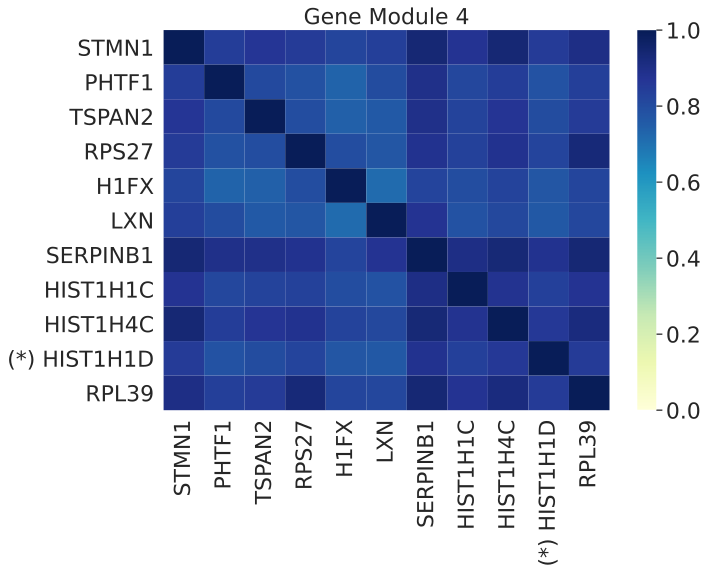

In [18]:
plot_suspect_module(4)

> We probably want to forbid genes with caution, since we expect the metacell analysis to help us expose any remaining genes we have missed. Here we only forbid the modules that strongly correlated with known suspect genes

In [19]:
forbidden_genes_mask = suspect_genes_mask
for gene_module in [4, 5, 47, 52]:
    module_genes_mask = module_of_genes == gene_module
    forbidden_genes_mask |= module_genes_mask
forbidden_gene_names = sorted(clean.var_names[forbidden_genes_mask])
print(len(forbidden_gene_names))
print(' '.join(forbidden_gene_names))

106
AGPAT2 C19orf38 CALM2 CAMK1 CD68 CEBPB CFD CFP CLIC1 COTL1 CPPED1 CSF3R CTSS DYNLL1 FCER1A FCN1 FOS GPX1 GSN GSTO1 GSTP1 H1FX HCK HIST1H1C HIST1H1D HIST1H4C HSP90AB1 HSPA1A ICAM4 IFI16 IFI27 IFI27L1 IFI27L2 IFI30 IFI35 IFI44 IFI44L IFI6 IFIH1 IFIT1 IFIT1B IFIT2 IFIT3 IFIT5 IFITM1 IFITM10 IFITM2 IFITM3 IFITM5 IGSF6 ISG15 JUN LGALS3 LGALS9 LILRB2 LRRC25 LXN MCM10 MCM2 MCM3 MCM3AP MCM3AP-AS1 MCM4 MCM5 MCM6 MCM7 MCM8 MCM9 MKI67 MS4A7 MTPN NCF2 PCNA PHTF1 PILRA PLAUR PSAP RGS2 RP11-290F20.3 RPL39 RPS27 S100A11 SAT1 SERPINA1 SERPINB1 SLC16A3 SMC1A SMC1B SMC2 SMC3 SMC4 SMC5 SMC5-AS1 SMC6 SMCO4 STMN1 STXBP2 TESC TMEM176A TMEM176B TOP2A TSPAN2 TYMP VIM WARS ZNF593


# 4. Computing Metacells
* Use `mc.pl.set_max_parallel_piles` to control number of piles processed in parallel, because processing each pile takes a significant amount of memory
* Use `mc.pl.guess_max_parallel_piles` to guess a reasonable number of piles based on data and resources
* Use `target_metacell_size` to set target UMI for each metacell (default = 160k, the metacell number will be between 3/4 * 160k and 2 * 160k)

## 4.1 Running Metacells

In [20]:
max_parallel_piles = mc.pl.guess_max_parallel_piles(clean)
print(max_parallel_piles)
mc.pl.set_max_parallel_piles(max_parallel_piles)

558


In [21]:
mc.pl.divide_and_conquer_pipeline(clean,
                                  forbidden_gene_names=forbidden_gene_names,
                                  random_seed=123456)

set PBMC.clean.var[rare_gene_module_0]: 4 true (0.01769%) out of 22617 bools
set PBMC.clean.var[rare_gene_module_1]: 29 true (0.1282%) out of 22617 bools
set PBMC.clean.var[rare_gene]: 33 true (0.1459%) out of 22617 bools
set PBMC.clean.obs[cells_rare_gene_module]: 149102 outliers (99.52%) out of 149825 int32 elements with 2 groups with mean size 361.5
set PBMC.clean.obs[rare_cell]: 723 true (0.4826%) out of 149825 bools
set PBMC.clean.uns[pre_directs]: 16
set PBMC.clean.uns[directs]: 24
set PBMC.clean.var[pre_high_total_gene]: 8269 positive (36.56%) out of 22617 int32s
set PBMC.clean.var[high_total_gene]: 10450 positive (46.2%) out of 22617 int32s
set PBMC.clean.var[pre_high_relative_variance_gene]: 11768 positive (52.03%) out of 22617 int32s
set PBMC.clean.var[high_relative_variance_gene]: 13249 positive (58.58%) out of 22617 int32s
set PBMC.clean.var[forbidden_gene]: 106 true (0.4687%) out of 22617 bools
set PBMC.clean.var[pre_feature_gene]: 447 positive (1.976%) out of 22617 int32s

> This has written many annotations for each cell, the most important one is `metacell`

In [22]:
metacells = mc.pl.collect_metacells(clean, name='PBMC.metacells')

set PBMC.metacells.var[excluded_gene]: 0 true (0%) out of 22617 bools
set PBMC.metacells.var[clean_gene]: 22617 true (100%) out of 22617 bools
set PBMC.metacells.var[forbidden_gene]: 106 true (0.4687%) out of 22617 bools
set PBMC.metacells.var[pre_feature_gene]: 447 positive (1.976%) out of 22617 int32s
set PBMC.metacells.var[feature_gene]: 711 positive (3.144%) out of 22617 int32s
set PBMC.metacells.obs[pile]: 1542 int32s
set PBMC.metacells.obs[candidate]: 1542 int32s


## 4.2 Visualization

### 4.2.1 Projecting on UMAP

In [23]:
# use min_dist to control how tight the points packed together
mc.pl.compute_umap_by_features(metacells, max_top_feature_genes=1000,
                               min_dist=2.0, random_seed=123456)

set PBMC.metacells.var[top_feature_gene]: 711 true (3.144%) out of 22617 bools
set PBMC.metacells.obsp[obs_balanced_ranks]: 14457 nonzero (0.608%) out of 2377764 elements
set PBMC.metacells.obsp[obs_pruned_ranks]: 5487 nonzero (0.2308%) out of 2377764 elements
set PBMC.metacells.obsp[obs_outgoing_weights]: 5487 nonzero (0.2308%) out of 2377764 elements
/opt/conda/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/opt/conda/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(
set PBMC.metacells.obs[umap_x]: 1542 float32s
set PBMC.metacells.obs[umap_y]: 1542 float32s


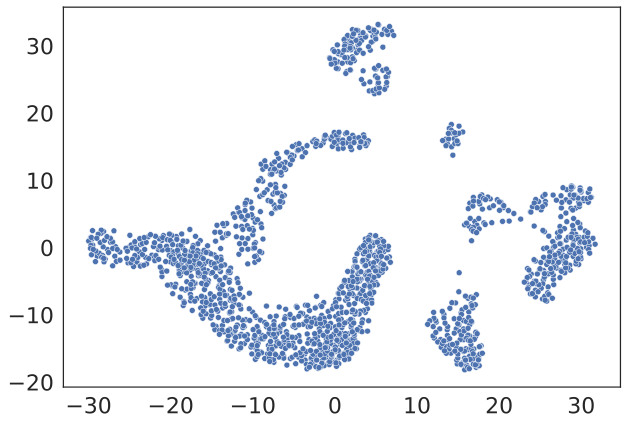

In [24]:
umap_x = mc.ut.get_o_numpy(metacells, 'umap_x')
umap_y = mc.ut.get_o_numpy(metacells, 'umap_y')
plot = sb.scatterplot(x=umap_x, y=umap_y)
plt.show()

### 4.2.2 visualize the (skeleton) KNN graph on top of the UMAP

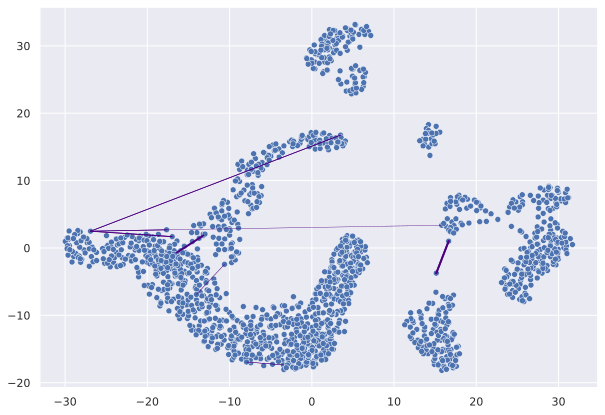

In [25]:
umap_edges = sp.coo_matrix(mc.ut.get_oo_proper(metacells, 'obs_outgoing_weights'))
min_long_edge_size = 4
sb.set()
plot = sb.scatterplot(x=umap_x, y=umap_y)
for (source_index, target_index, weight) \
        in zip(umap_edges.row, umap_edges.col, umap_edges.data):
    source_x = umap_x[source_index]
    target_x = umap_x[target_index]
    source_y = umap_y[source_index]
    target_y = umap_y[target_index]
    if hypot(target_x - source_x, target_y - source_y) >= min_long_edge_size:
        plt.plot([source_x, target_x], [source_y, target_y],
                 linewidth=weight * 2, color='indigo')
plt.show()

> Long edges indicate that UMAP did not capture this skeleton KNN graph well, or it might indicate that we are using some as features some “lateral” genes which are not relevant to the structure we are investigating.

In [26]:
clean.write('/mnt/data/SC-Reynolds-2021/metacells/cells.h5ad')
metacells.write('/mnt/data/SC-Reynolds-2021/metacells/metacells.h5ad')

# 5. Further analysis

> Further analysis methods are expected to create variable-sized groups of metacells with a similar “cell type” or gradients of metacells between such “cell types”, based on the gene programs they express. 

In [27]:
# read in PBMC 68k dataset metadata
annotation_68k = pd.read_csv('/mnt/data/SC-Reynolds-2021/metacells/68k_pbmc_barcodes_annotation.tsv', sep = '\t')
annotation_68k.index = [x + '-8batchall' for x in annotation_68k['barcodes']]
annotation_68k = annotation_68k[['celltype']]
annotation_68k.index.name = None

In [28]:
# add annotation
clean.obs = pd.merge(clean.obs, annotation_68k, left_index = True, right_index = True, how = 'left')
clean.obs['celltype'] = clean.obs.apply(lambda x: 'k68_' + x['celltype'] if x['batch'] == '8batchall' else x['batch'], axis = 1)

# get percentage of celltype per metacell
clean_celltype = clean.obs.groupby(['metacell','celltype']).size().unstack(fill_value = 0).rename_axis(None).rename_axis(None, axis = 1)
clean_celltype_pct = clean_celltype.div(clean_celltype.sum(axis = 1), axis = 0)
clean_celltype_pct.index = clean_celltype_pct.index.astype(str) 

In [29]:
# merge metacell metadata with the above percentage
metacells.obs = pd.merge(metacells.obs, clean_celltype_pct, left_index = True, right_index = True, how = 'left')

In [31]:
# generate expression data frame
metacells_expr = pd.DataFrame(metacells.X)
metacells_expr.columns = metacells.var_names
metacells_expr.index = metacells.obs_names

# combine expression with metadata together
metacells_output = pd.concat([metacells.obs, metacells_expr], axis = 1)
metacells_output.index.name = 'ID'

In [32]:
metacells_output.to_csv('/mnt/data/SC-Reynolds-2021/metacells/SC-Reynolds-2021.metacells.tsv', sep = '\t')

In [47]:
# output only top feature genes
metacells_top = metacells[:,metacells.var['top_feature_gene']]

# generate expression data frame
metacells_top_expr = pd.DataFrame(metacells_top.X)
metacells_top_expr.columns = metacells_top.var_names
metacells_top_expr.index = metacells_top.obs_names

# combine expression with metadata together
metacells_top_output = pd.concat([metacells_top.obs, metacells_top_expr], axis = 1)
metacells_top_output.index.name = 'ID'

metacells_top_output.to_csv('/mnt/data/SC-Reynolds-2021/metacells/SC-Reynolds-2021.metacells.top.tsv', sep = '\t')